In [6]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, jaccard_score, matthews_corrcoef, roc_curve, auc

In [7]:
def load_images_from_dir(dir_path):
    images = []
    labels = []
    for class_dir in os.listdir(dir_path):
        class_path = os.path.join(dir_path, class_dir)
        label = 1 if class_dir.lower() == 'fire' else 0
        for filename in os.listdir(class_path):
            img_path = os.path.join(class_path, filename)
            img = load_img(img_path, target_size=(150, 150))
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(label)
    return np.array(images), np.array(labels)

In [8]:
original_dir = '/kaggle/input/forest-fire-classification-dataset/ForestFireDataset(Classifications)/ForestFireDataset/train'
generated_dir = '/kaggle/input/forest-fire-classification-dataset/forest_fire_diffusion_generated/forest_fire_diffusion_generated'


original_images, original_labels = load_images_from_dir(original_dir)
generated_images, generated_labels = load_images_from_dir(generated_dir)

all_images = np.concatenate([original_images, generated_images], axis=0)
all_labels = np.concatenate([original_labels, generated_labels], axis=0)

all_images = all_images.astype('float32') / 255.0


In [9]:
print(f"Total images: {len(all_images)}, Total labels: {len(all_labels)}")

unique, counts = np.unique(all_labels, return_counts=True)
print(f"All labels distribution: {dict(zip(unique, counts))}")

Total images: 5148, Total labels: 5148
All labels distribution: {0: 2456, 1: 2692}


In [10]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def create_model_cnn(learning_rate=0.0001):
    
    input_layer = Input(shape=(150, 150, 3))

    x = Conv2D(32, (3, 3), activation='relu')(input_layer)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(64, (3, 3), activation='relu')(input_layer)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization()(x)

    x = Conv2D(256, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(512, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization()(x)
    
    
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x) 

    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x) 
    
    output_layer = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    
    model.compile(optimizer=Adam(learning_rate=learning_rate), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    
    return model

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (confusion_matrix, roc_curve, auc, precision_score,
                             recall_score, f1_score, jaccard_score, matthews_corrcoef)
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

fold_train_loss = []
fold_val_loss = []
fold_train_acc = []
fold_val_acc = []
confusion_matrices = []
roc_aucs = []

precision_list = []
recall_list = []
f1_list = []
jaccard_list = []
mcc_list = []

all_labels = np.array(all_labels) 

all_true_labels = []
all_predictions = []

fold_num = 1
for train_index, val_index in kf.split(all_images):
    print(f"Fold {fold_num}")
    X_train, X_val = all_images[train_index], all_images[val_index]
    y_train, y_val = all_labels[train_index], all_labels[val_index]
    
    datagen = ImageDataGenerator(rotation_range=5, width_shift_range=0.1,
                                 height_shift_range=0.1, shear_range=0.1,
                                 zoom_range=0.1, horizontal_flip=True)
    datagen.fit(X_train)

 
    model = create_model_cnn(learning_rate=0.0001)
    

    early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
    

    history = model.fit(datagen.flow(X_train, y_train, batch_size=32), 
                        validation_data=(X_val, y_val), 
                        epochs=50, 
                        callbacks=[early_stopping],
                        verbose=1)
    
    train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
    print(f"Training loss: {train_loss}, Training accuracy: {train_accuracy}")
    

    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    print(f"Validation loss: {val_loss}, Validation accuracy: {val_accuracy}")

    
    fold_train_loss.append(history.history['loss'])
    fold_val_loss.append(history.history['val_loss'])
    fold_train_acc.append(history.history['accuracy'])
    fold_val_acc.append(history.history['val_accuracy'])


    y_val_pred = model.predict(X_val, verbose=0)
    y_val_pred_class = np.where(y_val_pred > 0.5, 1, 0).flatten()


    all_true_labels.append(y_val)
    all_predictions.append(y_val_pred)

    cm = confusion_matrix(y_val, y_val_pred_class)
    confusion_matrices.append(cm)
    
    precision = precision_score(y_val, y_val_pred_class)
    recall = recall_score(y_val, y_val_pred_class)
    f1 = f1_score(y_val, y_val_pred_class)
    jaccard = jaccard_score(y_val, y_val_pred_class)
    mcc = matthews_corrcoef(y_val, y_val_pred_class)
    
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    jaccard_list.append(jaccard)
    mcc_list.append(mcc)

    fold_num += 1


average_precision = np.mean(precision_list)
average_recall = np.mean(recall_list)
average_f1 = np.mean(f1_list)
average_jaccard = np.mean(jaccard_list)
average_mcc = np.mean(mcc_list)

average_train_loss = np.mean([loss[-1] for loss in fold_train_loss])
average_val_loss = np.mean([loss[-1] for loss in fold_val_loss])
average_train_acc = np.mean([acc[-1] for acc in fold_train_acc])
average_val_acc = np.mean([acc[-1] for acc in fold_val_acc])

print(f"\nAverage Training Loss: {average_train_loss:.4f}")
print(f"Average Validation Loss: {average_val_loss:.4f}")
print(f"Average Training Accuracy: {average_train_acc:.4f}")
print(f"Average Validation Accuracy: {average_val_acc:.4f}")

print(f"\nAverage Precision: {average_precision:.4f}")
print(f"Average Recall: {average_recall:.4f}")
print(f"Average F1 Score: {average_f1:.4f}")
print(f"Average Jaccard Index: {average_jaccard:.4f}")
print(f"Average MCC: {average_mcc:.4f}")


Fold 1
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1730992066.237676      99 service.cc:145] XLA service 0x79c9c4002ae0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730992066.237742      99 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/129 ━━━━━━━━━━━━━━━━━━━━ 28:01 13s/step - accuracy: 0.4688 - loss: 1.4605

I0000 00:00:1730992074.825311      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


129/129 ━━━━━━━━━━━━━━━━━━━━ 40s 212ms/step - accuracy: 0.7852 - loss: 0.6590 - val_accuracy: 0.5039 - val_loss: 0.6528
Epoch 2/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 20s 145ms/step - accuracy: 0.8529 - loss: 0.4814 - val_accuracy: 0.4864 - val_loss: 1.4393
Epoch 3/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 20s 144ms/step - accuracy: 0.9043 - loss: 0.3321 - val_accuracy: 0.8592 - val_loss: 0.3223
Epoch 4/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 20s 144ms/step - accuracy: 0.9198 - loss: 0.3218 - val_accuracy: 0.8932 - val_loss: 0.2996
Epoch 5/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 20s 144ms/step - accuracy: 0.9284 - loss: 0.2555 - val_accuracy: 0.9252 - val_loss: 0.1997
Epoch 6/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 19s 140ms/step - accuracy: 0.9346 - loss: 0.2457 - val_accuracy: 0.9534 - val_loss: 0.1304
Epoch 7/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 19s 142ms/step - accuracy: 0.9383 - loss: 0.1893 - val_accuracy: 0.9583 - val_loss: 0.1369
Epoch 8/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 20s 144ms/step - accuracy: 0.9408 - loss: 0.1912 - val

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


129/129 ━━━━━━━━━━━━━━━━━━━━ 31s 180ms/step - accuracy: 0.7826 - loss: 0.6842 - val_accuracy: 0.5252 - val_loss: 0.6488
Epoch 2/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 19s 142ms/step - accuracy: 0.8635 - loss: 0.4831 - val_accuracy: 0.8146 - val_loss: 0.4976
Epoch 3/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 19s 141ms/step - accuracy: 0.8905 - loss: 0.4120 - val_accuracy: 0.6612 - val_loss: 0.6504
Epoch 4/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 19s 141ms/step - accuracy: 0.9027 - loss: 0.3494 - val_accuracy: 0.8816 - val_loss: 0.2726
Epoch 5/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 19s 142ms/step - accuracy: 0.9191 - loss: 0.2752 - val_accuracy: 0.9398 - val_loss: 0.1812
Epoch 6/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 19s 140ms/step - accuracy: 0.9205 - loss: 0.2576 - val_accuracy: 0.9680 - val_loss: 0.0831
Epoch 7/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 19s 142ms/step - accuracy: 0.9415 - loss: 0.2114 - val_accuracy: 0.9573 - val_loss: 0.1097
Epoch 8/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 19s 141ms/step - accuracy: 0.9465 - loss: 0.1856 - val

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


129/129 ━━━━━━━━━━━━━━━━━━━━ 31s 180ms/step - accuracy: 0.7936 - loss: 0.6650 - val_accuracy: 0.4534 - val_loss: 1.3079
Epoch 2/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 20s 143ms/step - accuracy: 0.8595 - loss: 0.5195 - val_accuracy: 0.5107 - val_loss: 0.6911
Epoch 3/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 20s 144ms/step - accuracy: 0.8958 - loss: 0.3617 - val_accuracy: 0.7631 - val_loss: 0.4705
Epoch 4/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 19s 142ms/step - accuracy: 0.9146 - loss: 0.3109 - val_accuracy: 0.7612 - val_loss: 0.6930
Epoch 5/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 19s 143ms/step - accuracy: 0.9229 - loss: 0.2585 - val_accuracy: 0.9592 - val_loss: 0.1396
Epoch 6/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 19s 143ms/step - accuracy: 0.9209 - loss: 0.2881 - val_accuracy: 0.9456 - val_loss: 0.1900
Epoch 7/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 19s 141ms/step - accuracy: 0.9483 - loss: 0.1846 - val_accuracy: 0.9631 - val_loss: 0.1383
Epoch 8/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 19s 141ms/step - accuracy: 0.9457 - loss: 0.1794 - val

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


129/129 ━━━━━━━━━━━━━━━━━━━━ 35s 207ms/step - accuracy: 0.7871 - loss: 0.6500 - val_accuracy: 0.5044 - val_loss: 0.7014
Epoch 2/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 19s 141ms/step - accuracy: 0.8748 - loss: 0.4070 - val_accuracy: 0.7969 - val_loss: 0.4819
Epoch 3/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 19s 141ms/step - accuracy: 0.8858 - loss: 0.4091 - val_accuracy: 0.7532 - val_loss: 0.5179
Epoch 4/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 19s 141ms/step - accuracy: 0.9091 - loss: 0.3253 - val_accuracy: 0.9135 - val_loss: 0.2091
Epoch 5/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 19s 140ms/step - accuracy: 0.9249 - loss: 0.2663 - val_accuracy: 0.9427 - val_loss: 0.2062
Epoch 6/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 19s 140ms/step - accuracy: 0.9260 - loss: 0.2710 - val_accuracy: 0.9543 - val_loss: 0.1488
Epoch 7/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 19s 138ms/step - accuracy: 0.9397 - loss: 0.1902 - val_accuracy: 0.9213 - val_loss: 0.2171
Epoch 8/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 19s 139ms/step - accuracy: 0.9372 - loss: 0.2239 - val

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


129/129 ━━━━━━━━━━━━━━━━━━━━ 31s 181ms/step - accuracy: 0.7888 - loss: 0.7004 - val_accuracy: 0.4655 - val_loss: 0.7324
Epoch 2/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 19s 140ms/step - accuracy: 0.8740 - loss: 0.4626 - val_accuracy: 0.4655 - val_loss: 1.5666
Epoch 3/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 19s 140ms/step - accuracy: 0.8874 - loss: 0.3970 - val_accuracy: 0.4859 - val_loss: 1.9648
Epoch 4/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 20s 143ms/step - accuracy: 0.9092 - loss: 0.3462 - val_accuracy: 0.8484 - val_loss: 0.3895
Epoch 5/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 19s 139ms/step - accuracy: 0.9202 - loss: 0.2964 - val_accuracy: 0.9125 - val_loss: 0.2443
Epoch 6/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 19s 140ms/step - accuracy: 0.9271 - loss: 0.2438 - val_accuracy: 0.9397 - val_loss: 0.2441
Epoch 7/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 19s 142ms/step - accuracy: 0.9303 - loss: 0.2509 - val_accuracy: 0.9553 - val_loss: 0.1950
Epoch 8/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 19s 141ms/step - accuracy: 0.9365 - loss: 0.2375 - val

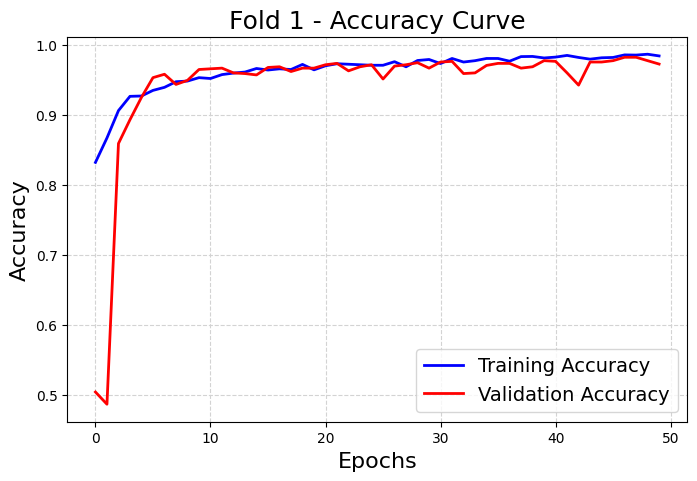

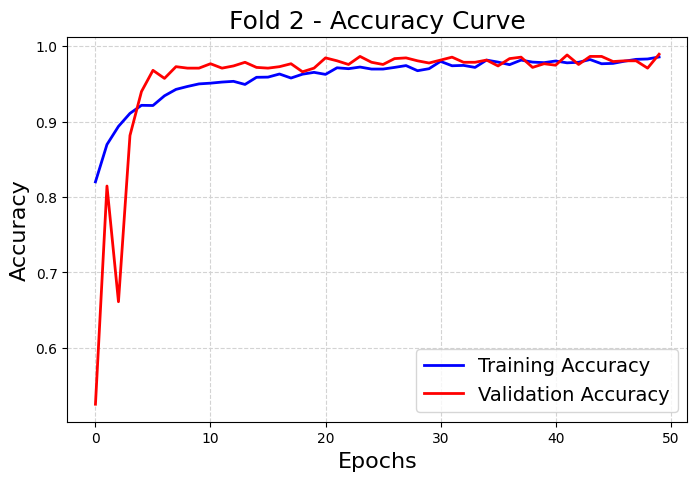

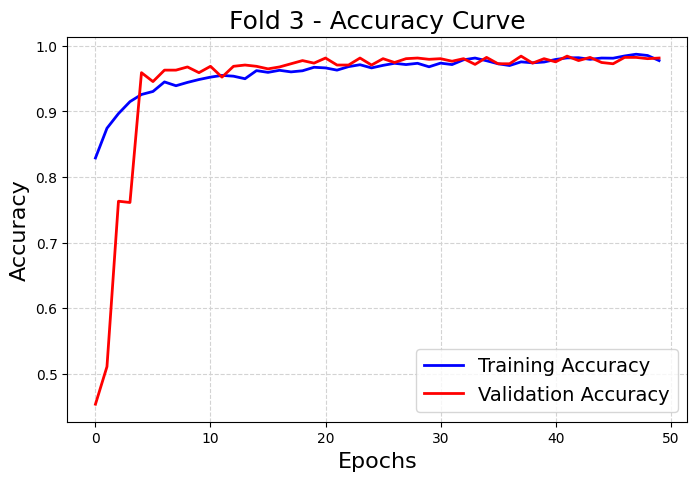

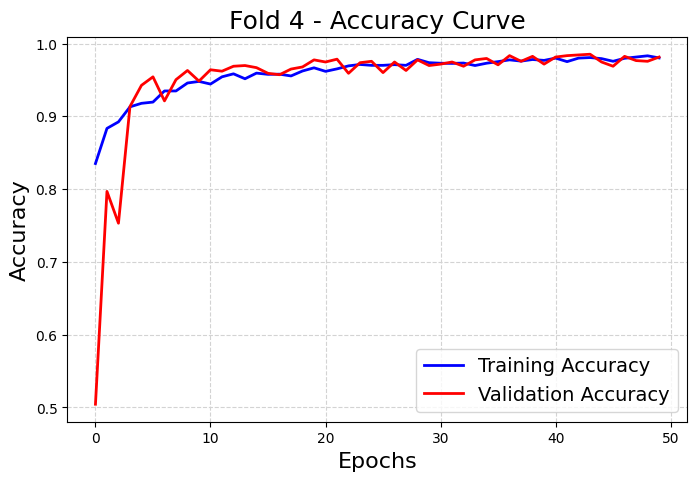

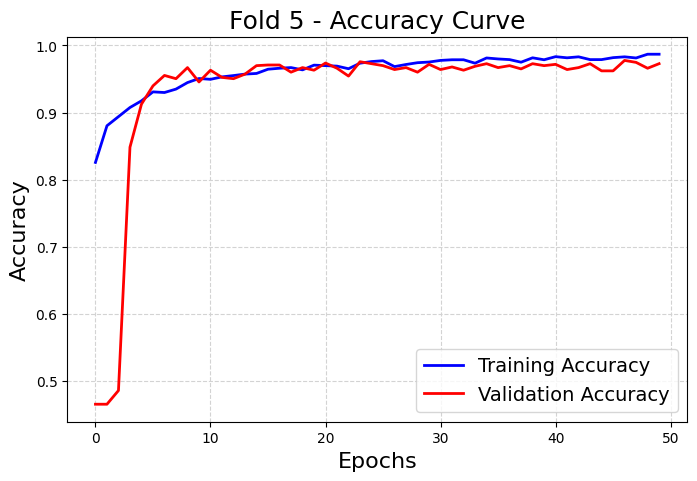

In [12]:
import matplotlib.pyplot as plt


for i in range(k):
    plt.figure(figsize=(8, 5))
    plt.plot(fold_train_acc[i], label='Training Accuracy', color='blue', linewidth=2)
    plt.plot(fold_val_acc[i], label='Validation Accuracy', color='red', linewidth=2)
    plt.title(f'Fold {i + 1} - Accuracy Curve', fontsize=18)
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Accuracy', fontsize=16)
    plt.grid(True, color='lightgrey', linestyle='--')
    plt.legend(fontsize=14, loc='best')
    plt.show()


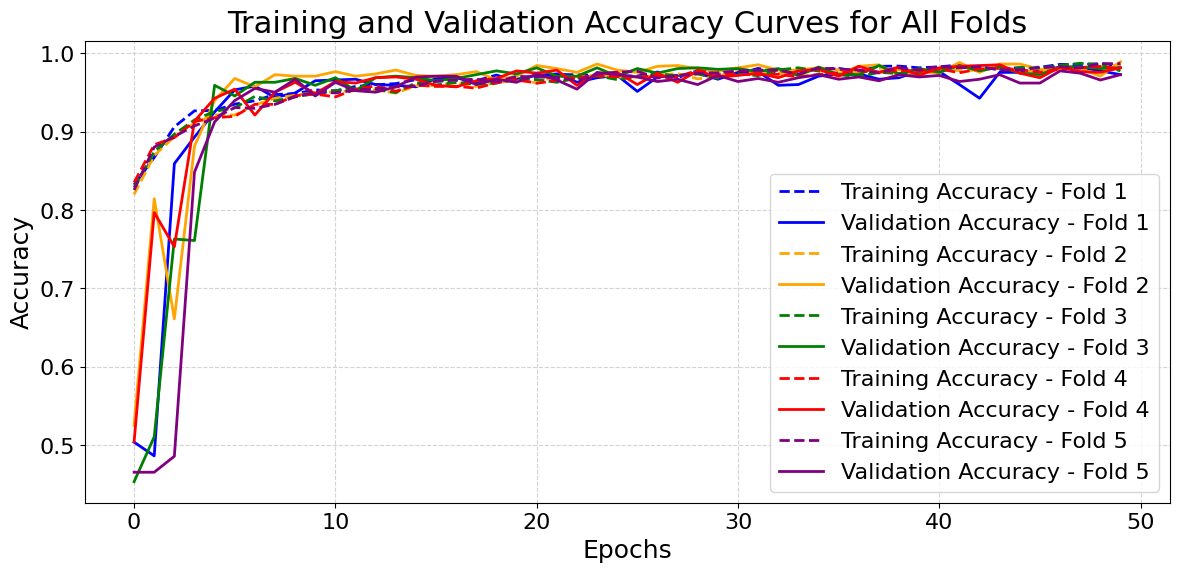

In [14]:
import matplotlib.pyplot as plt

colors = ['blue', 'orange', 'green', 'red', 'purple']

plt.figure(figsize=(14, 6))

for i in range(k):
    plt.plot(fold_train_acc[i], label=f'Training Accuracy - Fold {i + 1}', color=colors[i], linestyle='--', linewidth=2)
    plt.plot(fold_val_acc[i], label=f'Validation Accuracy - Fold {i + 1}', color=colors[i], linewidth=2)

plt.title('Training and Validation Accuracy Curves for All Folds', fontsize=22)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)


plt.grid(True, color='lightgrey', linestyle='--')
plt.legend(loc='lower right', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()


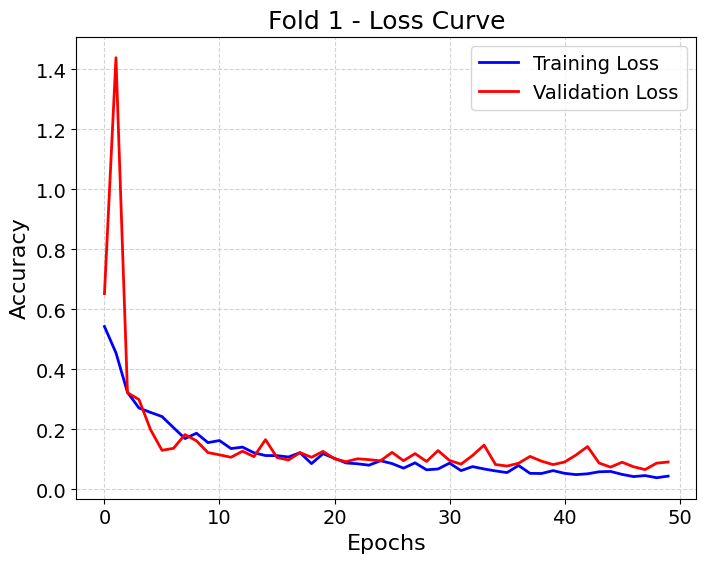

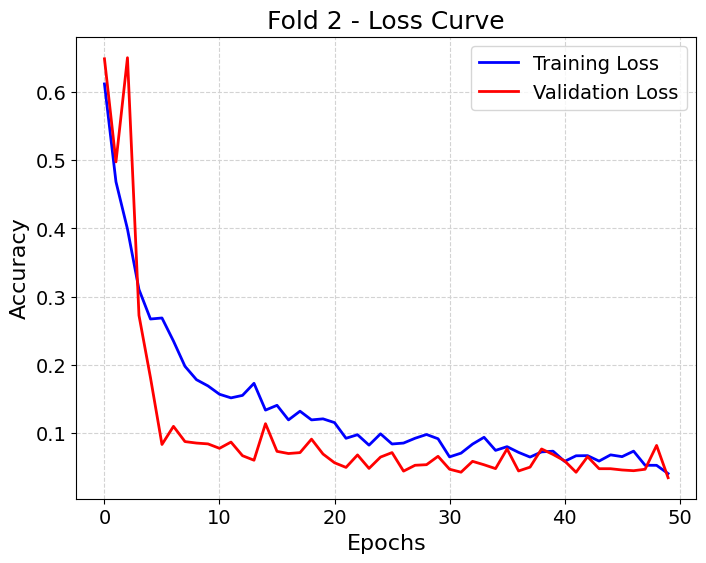

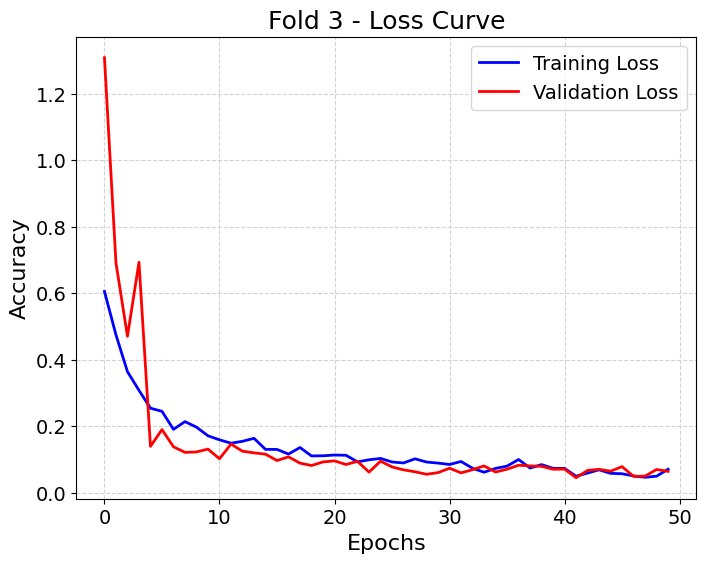

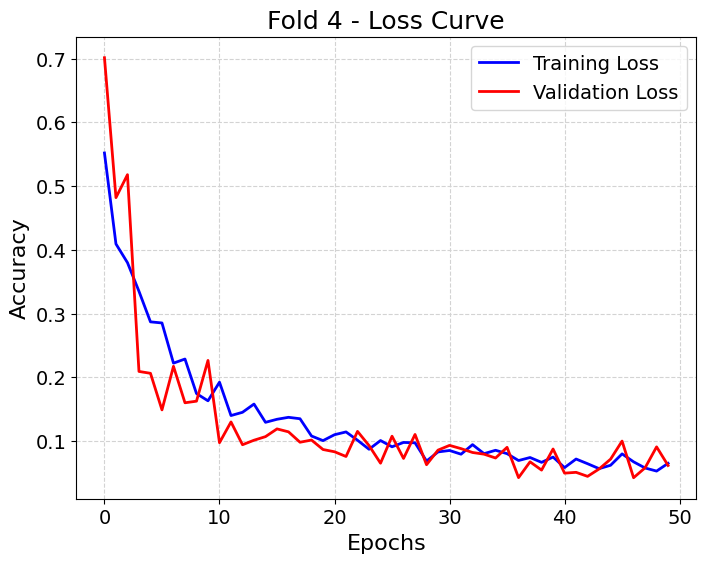

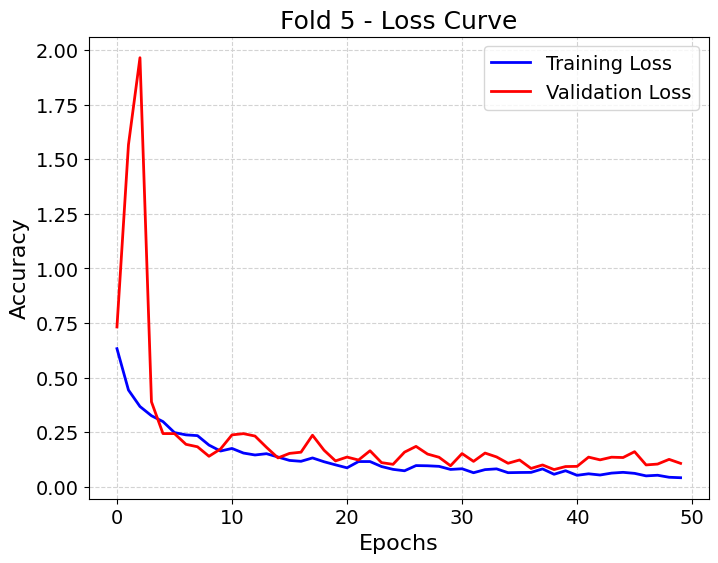

In [16]:
import matplotlib.pyplot as plt


for i in range(k):
    plt.figure(figsize=(8, 6))
    plt.plot(fold_train_loss[i], label='Training Loss', color='blue', linewidth=2)
    plt.plot(fold_val_loss[i], label='Validation Loss', color='red', linewidth=2)
    plt.title(f'Fold {i + 1} - Loss Curve', fontsize=18)
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Accuracy', fontsize=16)
    plt.grid(True, color='lightgrey', linestyle='--')
    plt.legend(fontsize=14, loc='best')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

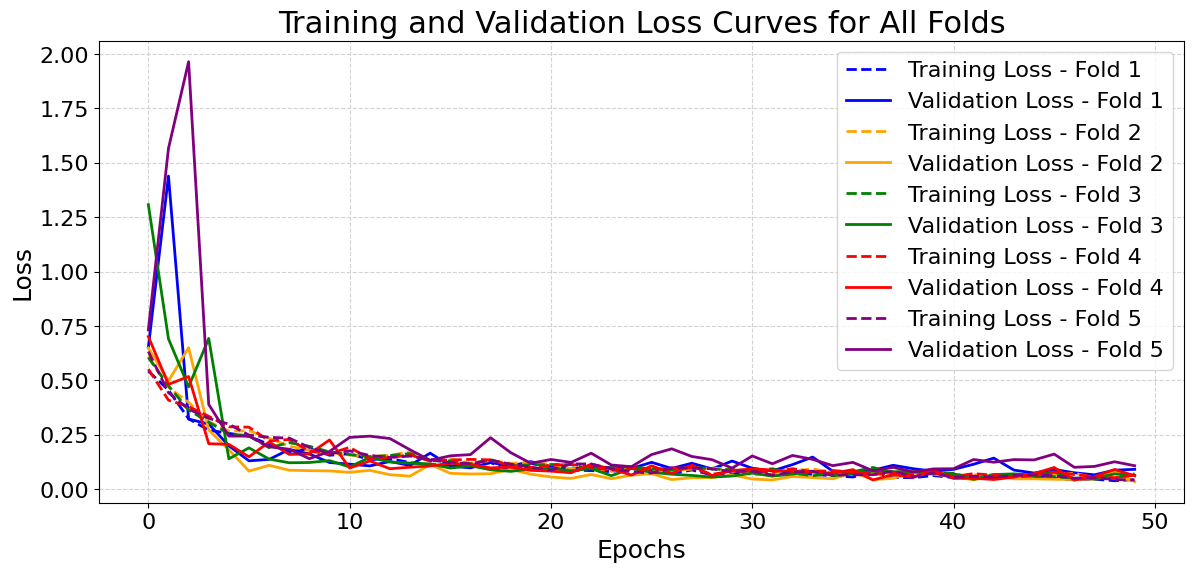

In [18]:
import matplotlib.pyplot as plt

colors = ['blue', 'orange', 'green', 'red', 'purple']

plt.figure(figsize=(14, 6))

for i in range(k):
    plt.plot(fold_train_loss[i], label=f'Training Loss - Fold {i + 1}', color=colors[i], linestyle='--', linewidth=2)
    plt.plot(fold_val_loss[i], label=f'Validation Loss - Fold {i + 1}', color=colors[i], linewidth=2)

plt.title('Training and Validation Loss Curves for All Folds', fontsize=22)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.grid(True, color='lightgrey', linestyle='--')
plt.legend(loc='upper right', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()


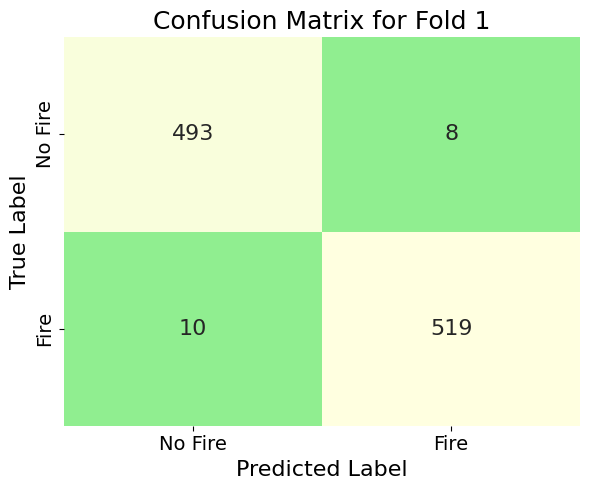

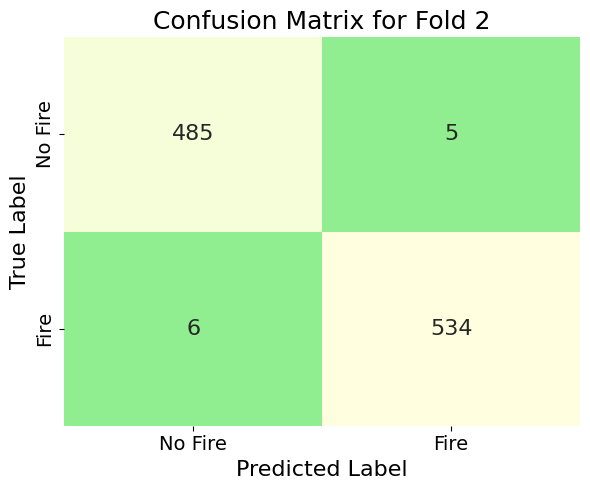

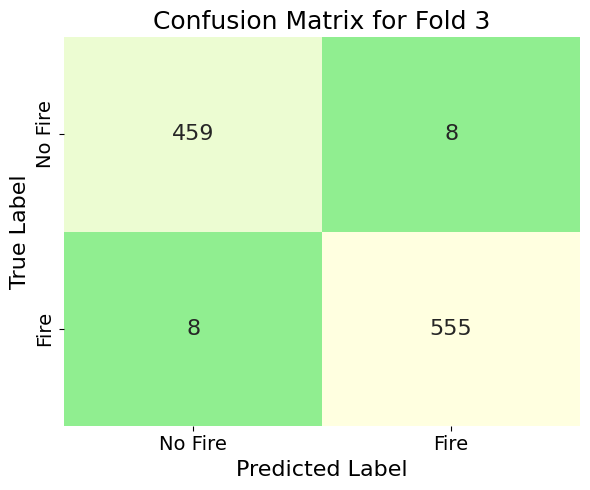

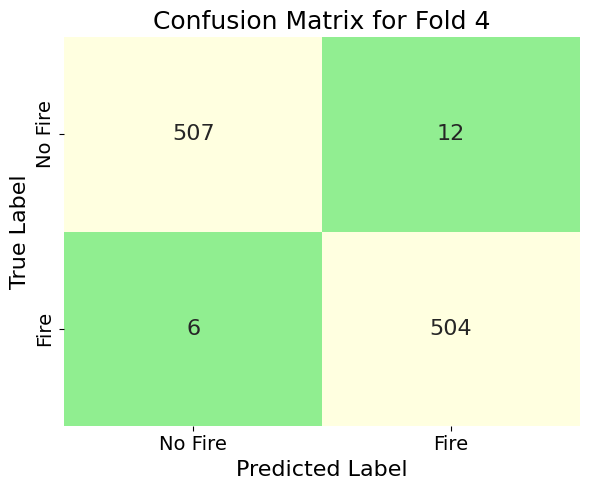

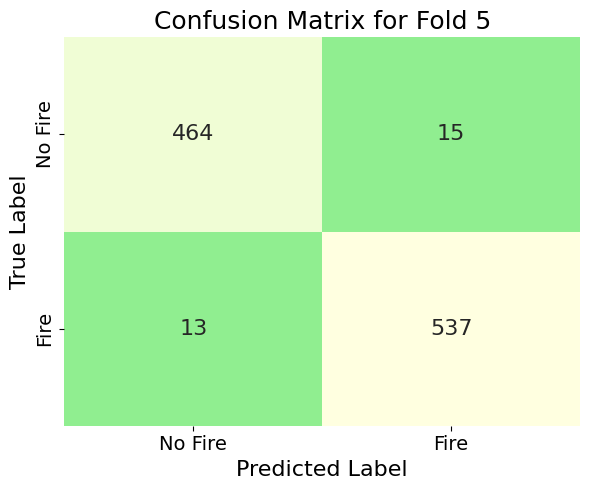

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

custom_cmap = LinearSegmentedColormap.from_list('custom_green_yellow', ['lightgreen', 'lightyellow'])

for i, cm in enumerate(confusion_matrices):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap=custom_cmap, cbar=False, annot_kws={"size": 16},
                xticklabels=['No Fire', 'Fire'], yticklabels=['No Fire', 'Fire'])
    plt.title(f'Confusion Matrix for Fold {i + 1}', fontsize=18)
    plt.xlabel('Predicted Label', fontsize=16)
    plt.ylabel('True Label', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.show()


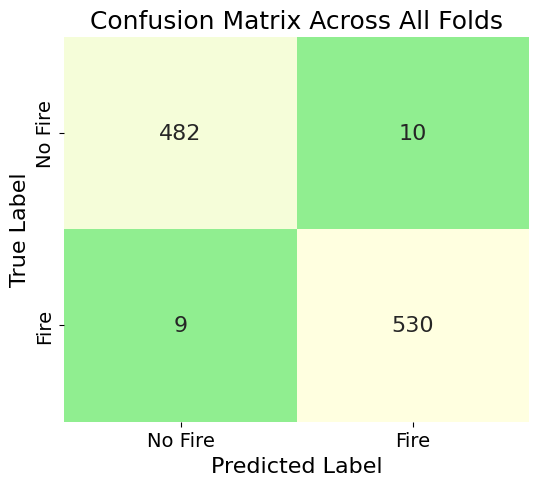

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

custom_cmap = LinearSegmentedColormap.from_list('custom_green_yellow', ['lightgreen', 'lightyellow'])

average_cm = np.mean(confusion_matrices, axis=0)
average_cm = np.round(average_cm).astype(int)

plt.figure(figsize=(6, 5))
sns.heatmap(average_cm, annot=True, fmt='d', cmap=custom_cmap, cbar=False, annot_kws={"size": 16},
            xticklabels=['No Fire', 'Fire'], yticklabels=['No Fire', 'Fire'])
plt.title('Confusion Matrix Across All Folds', fontsize=18)
plt.xlabel('Predicted Label', fontsize=16)
plt.ylabel('True Label', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()


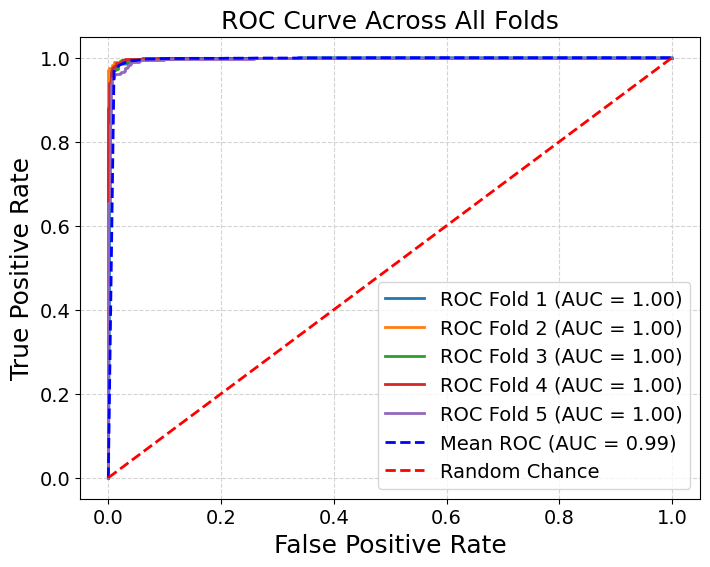

Average AUC across all folds: 0.9980


In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

mean_fpr = np.linspace(0, 1, 100)  
tprs = [] 
roc_aucs = []  

plt.figure(figsize=(8, 6))  

for i, (y_val, y_val_pred) in enumerate(zip(all_true_labels, all_predictions)):
    fpr, tpr, _ = roc_curve(y_val, y_val_pred)  
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0  

    roc_auc = auc(fpr, tpr)
    roc_aucs.append(roc_auc)

    plt.plot(fpr, tpr, lw=2, label=f'ROC Fold {i+1} (AUC = {roc_auc:.2f})')

mean_tpr = np.mean(tprs, axis=0)  
mean_tpr[-1] = 1.0  
mean_auc = auc(mean_fpr, mean_tpr)  
plt.plot(mean_fpr, mean_tpr, color='blue', lw=2, linestyle='--', label=f'Mean ROC (AUC = {mean_auc:.2f})')

plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Random Chance')

plt.title('ROC Curve Across All Folds', fontsize=18)
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.legend(loc='lower right', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True, color='lightgrey', linestyle='--')

plt.show()

print(f'Average AUC across all folds: {np.mean(roc_aucs):.4f}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


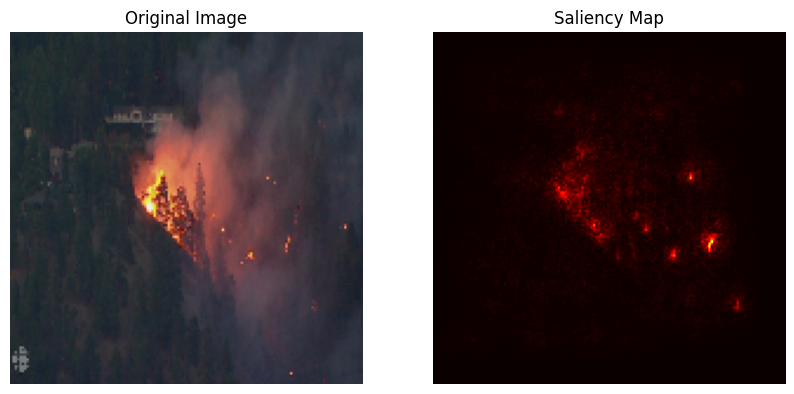

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import backend as K

def compute_saliency_map(model, img, class_index=None):
    img = np.expand_dims(img, axis=0)
    img = tf.convert_to_tensor(img, dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(img)  
        prediction = model(img, training=False)  

        if class_index is None:
            class_index = np.argmax(prediction[0])

        loss = prediction[:, class_index]  

    grads = tape.gradient(loss, img)
    saliency = np.max(np.abs(grads), axis=-1)[0]

    return saliency

def plot_saliency_map(original_img, saliency_map):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(original_img)
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    axes[1].imshow(saliency_map, cmap='hot')
    axes[1].set_title("Saliency Map")
    axes[1].axis('off')
    plt.show()

image_index = 279
original_img = X_val[image_index] 
class_index = np.argmax(model.predict(np.expand_dims(original_img, axis=0)))

saliency = compute_saliency_map(model, original_img, class_index)
plot_saliency_map(original_img, saliency)


In [34]:
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 148, 148, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 74, 74, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 72, 72, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 36, 36, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 36, 36, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 34, 34, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 17, 17, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 17, 17, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 15, 15, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 7, 7, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,592,069 (166.29 MB)

 Trainable params: 14,530,049 (55.43 MB)

 Non-trainable params: 1,920 (7.50 KB)

 Optimizer params: 29,060,100 (110.86 MB)

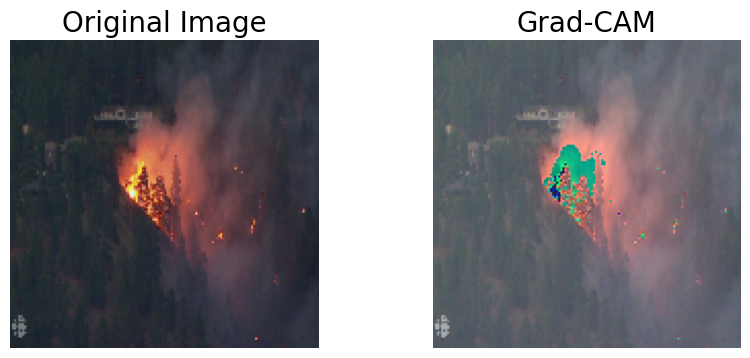

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import cv2

def get_gradcam(model, img_array, last_conv_layer_name, pred_index=None):
    last_conv_layer = model.get_layer(last_conv_layer_name)
    grad_model = Model(inputs=model.input, outputs=[last_conv_layer.output, model.output])
    
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0)
    
    if tf.reduce_max(heatmap) > 0:
        heatmap /= tf.reduce_max(heatmap)
    
    return heatmap.numpy()

def display_gradcam(img_array, heatmap, alpha=0.2):
    img = image.array_to_img(img_array)
    img = image.img_to_array(img)
    
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    
    heatmap_colored = cv2.applyColorMap(heatmap, cv2.COLORMAP_OCEAN)
    superimposed_img = heatmap_colored * alpha + img
    
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.title('Original Image', fontsize=20)
    plt.imshow(img.astype('uint8'))
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title('Grad-CAM', fontsize=20)
    plt.imshow(superimposed_img.astype('uint8'))
    plt.axis('off')
    plt.savefig('B_Gradcam271.pdf', format='pdf', dpi=600, bbox_inches='tight')
    plt.show()

specific_image_idx = 279
img_array = X_val[specific_image_idx]
img_array_normalized = img_array / 255.0

heatmap = get_gradcam(model, np.expand_dims(img_array_normalized, axis=0), last_conv_layer_name='conv2d_24')
display_gradcam(img_array, heatmap)
